[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Malkovsky/distributed-learning/blob/convergence/notebooks/CIFAR-10%20Convergence.ipynb)

## Setup

In [ ]:
# % rm -r distributed-learning/
! git clone --recurse-submodules https://github.com/Malkovsky/distributed-learning
% cd distributed-learning
! git checkout convergence

Cloning into 'distributed-learning'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 143 (delta 20), reused 21 (delta 13), pack-reused 108
Receiving objects: 100% (143/143), 21.64 MiB | 27.66 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Submodule 'wide-resnet.pytorch' (https://github.com/meliketoy/wide-resnet.pytorch.git) registered for path 'wide_resnet_submodule'
Cloning into '/content/distributed-learning/wide_resnet_submodule'...
remote: Enumerating objects: 13, done.        
remote: Counting objects: 100% (13/13), done.        
remote: Compressing objects: 100% (10/10), done.        
remote: Total 124 (delta 4), reused 11 (delta 3), pack-reused 111        
Receiving objects: 100% (124/124), 674.93 KiB | 24.10 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Submodule path 'wide_resnet_submodule': checked out '292b3ede0651e349dd566f9c23408aa572f1bd92'
/content/distributed-l

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pprint import pprint

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

import wide_resnet_submodule.config as cf
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from wide_resnet_submodule.networks import *
from networks.logreg_model_titanic import LogRegTitanic
from utils.graphs_config import ABC_3, TOP_5, LONELY, edges2topology, adj2edges
from utils.functions import *

In [ ]:
num_classes = 10

def get_model(model_name):
    if model_name == 'lenet':
        model = LeNet
        model_args = [num_classes]
    elif model_name == 'vggnet':
        model = VGG
        model_args = [11, num_classes] # VGGnet depth should be either 11, 13, 16, 19
    elif model_name == 'resnet':
        model = ResNet
        model_args = [18, num_classes] # Resnet depth should be either 18, 34, 50, 101, 152
    elif model_name == 'wide-resnet':
        model = Wide_ResNet
        model_args = [28, 10, 0.3, num_classes] # depth, widen_factor, dropout (Wide-resnet depth should be 6n+4)
    else:
        print('Error: Network should be either [LeNet / VGGNet / ResNet / Wide_ResNet', file=sys.stderr)
        exit(0)
    return model, model_args

criterion = nn.CrossEntropyLoss
learning_rate = 0.1

optimizer = optim.SGD
optimizer_kwargs = {'momentum': 0.9, 'weight_decay': 5e-4}

# Hyper Parameter settings
start_epoch, num_epochs, batch_size, optim_type = cf.start_epoch, cf.num_epochs, cf.batch_size, cf.optim_type

In [ ]:
dataset_name = 'cifar10'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
]) # meanstd transformation

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
])

trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                        train=True, download=True,
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                        train=False, download=False,
                                        transform=transform_test)

def get_train_loaders(topology):
    n_agents = len(topology)
    indices = [i for i in range(len(trainset))]
    np.random.shuffle(indices)
    indices = indices[:n_agents*(len(trainset) // n_agents)]
    indices = np.array_split(indices, n_agents)
    subsets = [torch.utils.data.Subset(trainset, indices=ind) for ind in indices]
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=2)
                for node_name, subset in zip(topology, subsets)
                }
    return train_loaders

test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Extracting ../data/cifar10/cifar-10-python.tar.gz to ../data/cifar10


In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Yes, we use CUDA!")
else:
    print("CUDA is not available. Check your drivers.")

Yes, we use CUDA!


In [ ]:
def consensus_model(topology, epochs=num_epochs, consensus=True, model_name='lenet'):
    update_params_epoch_start = 1 if consensus else epochs + 1

    statistics = {func_name: {node_name: {'values': [], 'iters': [], 'tmp': 0.0} 
                          for node_name in topology}
              for func_name in stat_funcs}
    
    train_loaders = get_train_loaders(topology)
    epoch_len = min(len(tl) for tl in train_loaders.values())

    master = MasterNode(node_names=topology.keys(),
                        weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                        train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                        test_loader=test_loader, # general test loader
                        fit_step=fit_batch_cifar,
                        update_params=update_params_cifar,
                        stat_funcs=stat_funcs, # dict of statistic functions
                        statistics=statistics,
                        epoch=epochs, # number of epochs
                        epoch_len=epoch_len, # length each epoch
                        update_params_epoch_start=update_params_epoch_start, # the first epoch from which consensus begins
                        update_params_period=epoch_len, # consensus iteration period
                        use_cuda=use_cuda,
                        verbose=2 # verbose mode
                        )

    model, model_args = get_model(model_name)
    master.set_model(model, *model_args)
    master.set_optimizer(optimizer, optimizer_kwargs)
    master.set_error(criterion)
    master.initialize_nodes()
    master.start_consensus()
    return master

In [ ]:
! nvidia-smi

Tue Nov 17 21:13:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## LeNet experiments

In [ ]:
epochs = 100

stat_funcs = {'test_accuracy': calc_accuracy_cifar, 
              'cumulative_train_loss': get_cumulative_train_loss,
               'param_dev': get_flat_params_cifar}

In [ ]:
lonely = consensus_model(LONELY, consensus=False, epochs=epochs)

Master started



Epoch 1:
Node Model: epoch 1, iter 391, test_accuracy= 23.16
Node Model: epoch 1, iter 391, cumulative_train_loss= 2.26
Node Model: epoch 1, iter 391, param_dev= 0.00
Epoch 1 ended in 19.25 sec

Epoch 2:
Node Model: epoch 2, iter 782, test_accuracy= 32.62
Node Model: epoch 2, iter 782, cumulative_train_loss= 1.97
Node Model: epoch 2, iter 782, param_dev= 0.00
Epoch 2 ended in 3.93 sec

Epoch 3:
Node Model: epoch 3, iter 1173, test_accuracy= 36.72
Node Model: epoch 3, iter 1173, cumulative_train_loss= 1.78
Node Model: epoch 3, iter 1173, param_dev= 0.00
Epoch 3 ended in 3.69 sec

Epoch 4:
Node Model: epoch 4, iter 1564, test_accuracy= 40.62
Node Model: epoch 4, iter 1564, cumulative_train_loss= 1.69
Node Model: epoch 4, iter 1564, param_dev= 0.00
Epoch 4 ended in 3.85 sec

Epoch 5:
Node Model: epoch 5, iter 1955, test_accuracy= 42.06
Node Model: epoch 5, iter 1955, cumulative_train_loss= 1.62
Node Model: epoch 5, iter 1955, param_dev= 0.00
Epoch 5 ended in 3.80 sec

Epoch 6:
Node Model:

In [ ]:
abc3 = consensus_model(edges2topology(adj2edges(ABC_3)), epochs=epochs)

Master started



Epoch 1:
Node Bob: epoch 1, iter 131, test_accuracy= 8.40
Node Bob: epoch 1, iter 131, cumulative_train_loss= 2.30
Node Charlie: epoch 1, iter 131, test_accuracy= 12.32
Node Charlie: epoch 1, iter 131, cumulative_train_loss= 2.30
Node Alice: epoch 1, iter 131, test_accuracy= 12.47
Node Alice: epoch 1, iter 131, cumulative_train_loss= 2.27
Node Bob: epoch 1, iter 131, param_dev= 1.64
Node Charlie: epoch 1, iter 131, param_dev= 1.17
Node Alice: epoch 1, iter 131, param_dev= 1.50
Epoch 1 ended in 25.15 sec

Epoch 2:
Node Bob: epoch 2, iter 262, test_accuracy= 18.19
Node Bob: epoch 2, iter 262, cumulative_train_loss= 2.30
Node Charlie: epoch 2, iter 262, test_accuracy= 17.29
Node Charlie: epoch 2, iter 262, cumulative_train_loss= 2.30
Node Alice: epoch 2, iter 262, test_accuracy= 16.45
Node Alice: epoch 2, iter 262, cumulative_train_loss= 2.26
Node Bob: epoch 2, iter 262, param_dev= 0.39
Node Charlie: epoch 2, iter 262, param_dev= 0.22
Node Alice: epoch 2, iter 262, param_dev= 0.30
Epoch 2

In [ ]:
top5 = consensus_model(edges2topology(adj2edges(TOP_5)), epochs=epochs)

Master started



Epoch 1:
Node 0: epoch 1, iter 79, test_accuracy= 10.00
Node 0: epoch 1, iter 79, cumulative_train_loss= 2.30
Node 1: epoch 1, iter 79, test_accuracy= 10.00
Node 1: epoch 1, iter 79, cumulative_train_loss= 2.30
Node 2: epoch 1, iter 79, test_accuracy= 10.00
Node 2: epoch 1, iter 79, cumulative_train_loss= 2.30
Node 3: epoch 1, iter 79, test_accuracy= 10.00
Node 3: epoch 1, iter 79, cumulative_train_loss= 2.30
Node 4: epoch 1, iter 79, test_accuracy= 10.00
Node 4: epoch 1, iter 79, cumulative_train_loss= 2.30
Node 0: epoch 1, iter 79, param_dev= 2.56
Node 1: epoch 1, iter 79, param_dev= 2.61
Node 2: epoch 1, iter 79, param_dev= 1.05
Node 3: epoch 1, iter 79, param_dev= 1.91
Node 4: epoch 1, iter 79, param_dev= 1.89
Epoch 1 ended in 30.03 sec

Epoch 2:
Node 0: epoch 2, iter 158, test_accuracy= 10.00
Node 0: epoch 2, iter 158, cumulative_train_loss= 2.30
Node 1: epoch 2, iter 158, test_accuracy= 10.00
Node 1: epoch 2, iter 158, cumulative_train_loss= 2.30
Node 2: epoch 2, iter 158, test_a

In [ ]:
def plot_stats(model, axs, **plot_kwargs):
    statistics = model.statistics
    for i, (func_name, node_stat) in enumerate(statistics.items()):
        axs[i].set_title(func_name, fontsize=20, pad=10.0)
        axs[i].set_xlabel('Epoch', fontsize=16)
        axs[i].set_ylabel(func_name, fontsize=16)
        for j, (node_name, stat) in enumerate(node_stat.items()):
            axs[i].plot(stat['iters'], stat['values'], label=node_name, **plot_kwargs)
        axs[i].legend(loc=0, fontsize=16)

def show_graphs(consensus, lonely):
    statistics = consensus.statistics
    fig, axs = plt.subplots(figsize=(26, 8), ncols=len(statistics))
    fig.suptitle('Consensus vs. lonely', fontsize=24)
    fig.tight_layout(pad=7.0)
    plot_stats(consensus, axs, linestyle='--', color='k')
    plot_stats(lonely, axs, color='r')

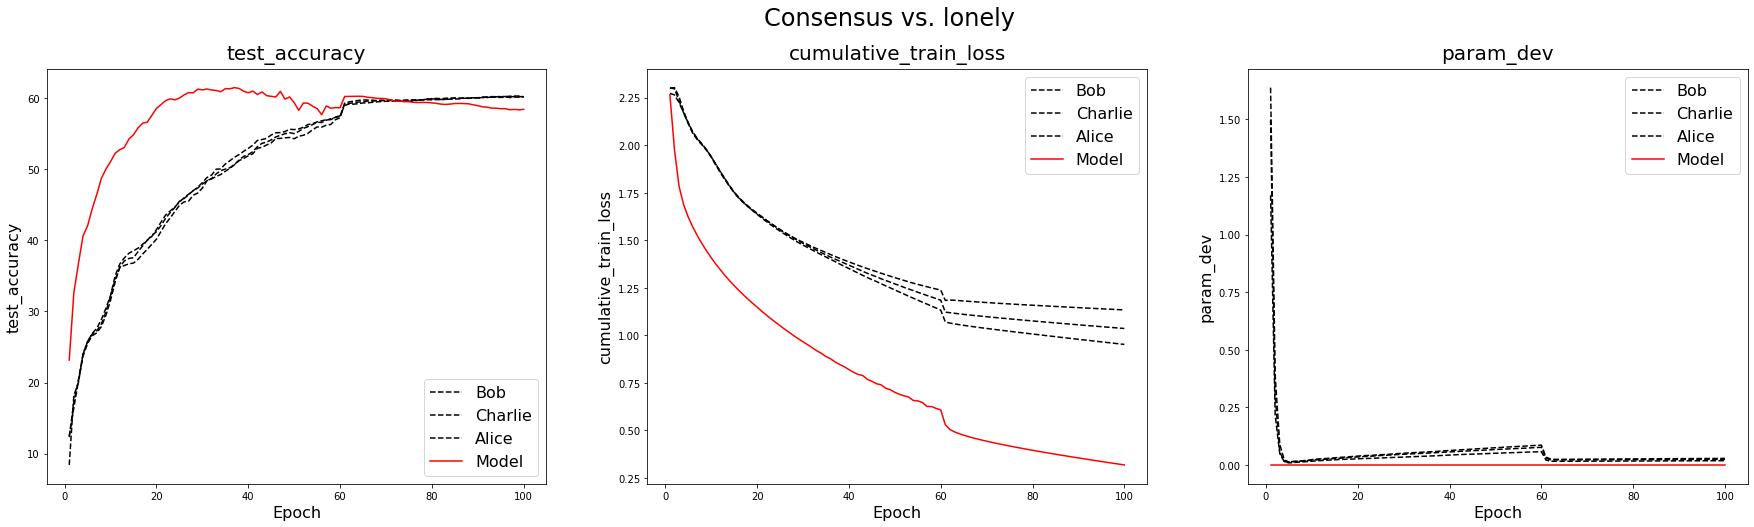

In [ ]:
show_graphs(abc3, lonely)

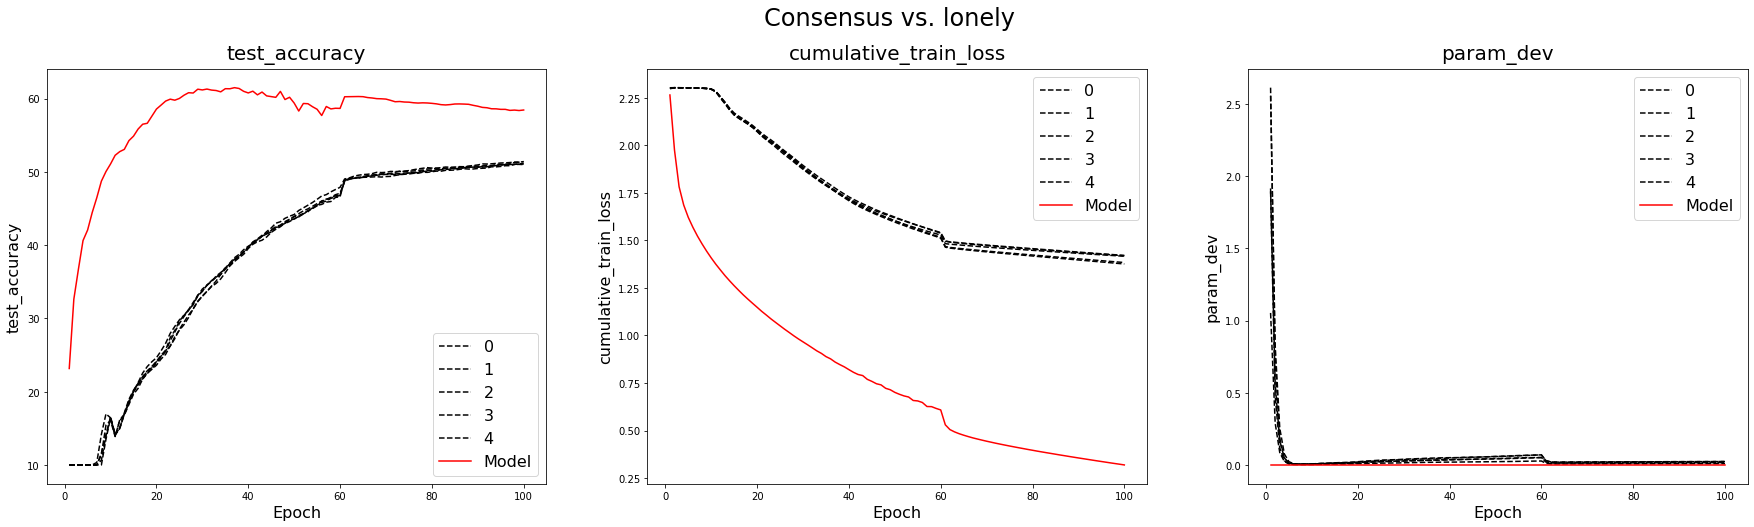

In [ ]:
show_graphs(top5, lonely)

## Wide ResNet experiments

In [ ]:
epochs = 20

stat_funcs = {'test_accuracy': calc_accuracy_cifar, 
              'cumulative_train_loss': get_cumulative_train_loss}

In [ ]:
lonely = consensus_model(LONELY, consensus=False, epochs=epochs, model_name='wide-resnet')

| Wide-Resnet 28x10
Master started



Epoch 1:
Node Model: epoch 1, iter 391, test_accuracy= 32.23
Node Model: epoch 1, iter 391, cumulative_train_loss= 1.77
Epoch 1 ended in 299.63 sec

Epoch 2:
Node Model: epoch 2, iter 782, test_accuracy= 51.12
Node Model: epoch 2, iter 782, cumulative_train_loss= 1.38
Epoch 2 ended in 294.00 sec

Epoch 3:
Node Model: epoch 3, iter 1173, test_accuracy= 54.03
Node Model: epoch 3, iter 1173, cumulative_train_loss= 1.11
Epoch 3 ended in 294.10 sec

Epoch 4:
Node Model: epoch 4, iter 1564, test_accuracy= 54.49
Node Model: epoch 4, iter 1564, cumulative_train_loss= 0.94
Epoch 4 ended in 294.08 sec

Epoch 5:
Node Model: epoch 5, iter 1955, test_accuracy= 55.65
Node Model: epoch 5, iter 1955, cumulative_train_loss= 0.83
Epoch 5 ended in 294.78 sec

Epoch 6:
Node Model: epoch 6, iter 2346, test_accuracy= 62.92
Node Model: epoch 6, iter 2346, cumulative_train_loss= 0.73
Epoch 6 ended in 294.38 sec

Epoch 7:
Node Model: epoch 7, iter 2737, test_accuracy= 65.46
Node Model: epoch 7, iter 2737, cumu

In [ ]:
abc3 = consensus_model(edges2topology(adj2edges(ABC_3)), epochs=epochs, model_name='wide-resnet')

| Wide-Resnet 28x10
| Wide-Resnet 28x10
| Wide-Resnet 28x10
Master started



Epoch 1:
Node Alice: epoch 1, iter 131, test_accuracy= 10.00
Node Alice: epoch 1, iter 131, cumulative_train_loss= 1.95
Node Bob: epoch 1, iter 131, test_accuracy= 10.01
Node Bob: epoch 1, iter 131, cumulative_train_loss= 1.96
Node Charlie: epoch 1, iter 131, test_accuracy= 10.00
Node Charlie: epoch 1, iter 131, cumulative_train_loss= 1.96
Epoch 1 ended in 337.33 sec

Epoch 2:
Node Alice: epoch 2, iter 262, test_accuracy= 26.47
Node Alice: epoch 2, iter 262, cumulative_train_loss= 1.84
Node Bob: epoch 2, iter 262, test_accuracy= 18.85
Node Bob: epoch 2, iter 262, cumulative_train_loss= 1.80
Node Charlie: epoch 2, iter 262, test_accuracy= 14.92
Node Charlie: epoch 2, iter 262, cumulative_train_loss= 1.76
Epoch 2 ended in 331.75 sec

Epoch 3:
Node Alice: epoch 3, iter 393, test_accuracy= 35.82
Node Alice: epoch 3, iter 393, cumulative_train_loss= 1.61
Node Bob: epoch 3, iter 393, test_accuracy= 37.15
Node Bob: epoch 3, iter 393, cumulative_train_loss= 1.58
Node Charlie: epoch 3, iter 393

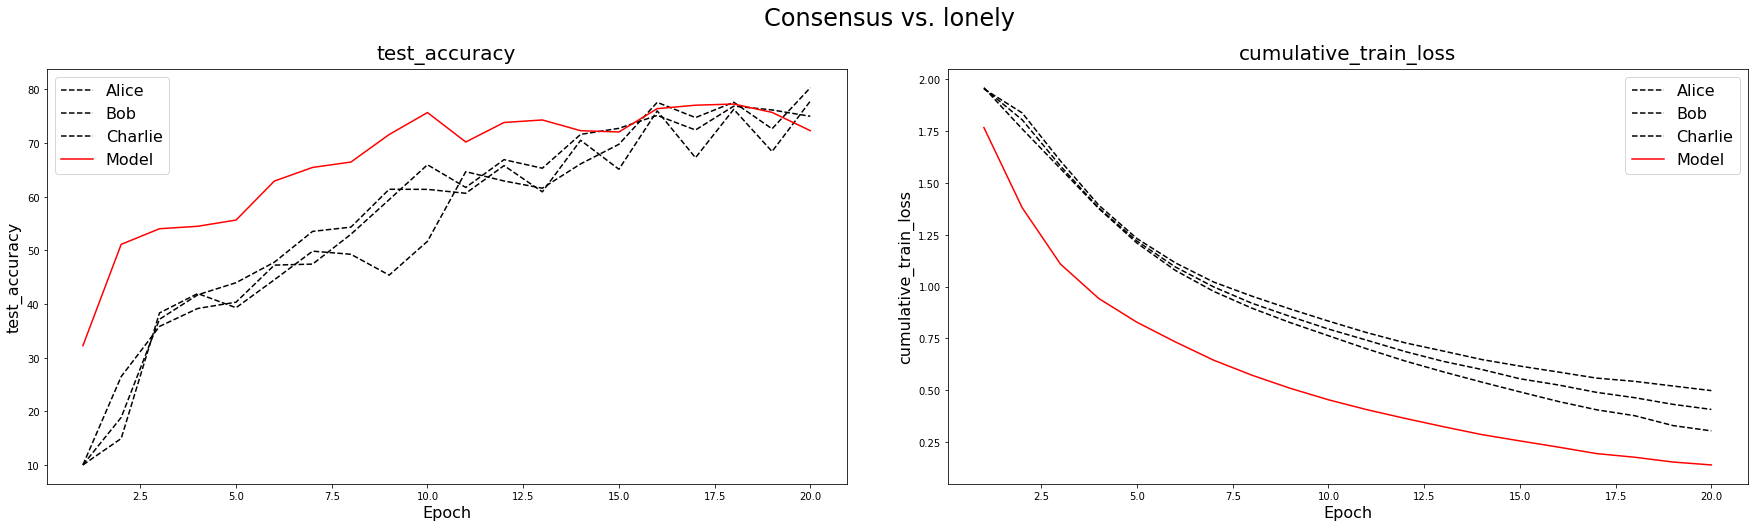

In [ ]:
show_graphs(abc3, lonely)